<h1 align="center"> Charge Redistribution DAC Modelling </h1>

<p align="justify"> 
In this practical class, the modelling method for a DAC based on a capacitive array is thoroughly described, 
considering the effects of parasitic capacitances, amplifier offset, noise and delay.
</p>

In [1]:
from functools import partial

# mathematical computing
import numpy as np
import scipy as sp
from scipy import signal # to generate the noise signal
import seaborn as sns # to observe the noise signal's histogram

sns.set_theme()
sns.set_palette("colorblind")

from numpy.random import uniform, normal # random numbers fitted into a uniform distribution
# plotting
import matplotlib.pyplot as plt
# import the models and utilities functions
from utils import ideal_dac, ideal_adc, nonideal_adc, dec2bin, bin2dec

%matplotlib inline

In [2]:
# number of simulation points
Np = 1000
# define the time base
Fs = 1e9 # Hz
Ts = 1/Fs # s
tD = np.arange(0,Np)*Ts; # (0:Np-1) == np.arange(0,Np)

<h2 align="left"> Capacitive DAC - Charge Redistribution </h2>

<p align="jusitfy">
Understanding the operation of the capacitive DAC is essential to significantly ease the effort of understanding the capacitive-based/charge redistribution ADCs, which are is the most common ADC architecture in modern circuits. The classical capacitive DAC architecture is presented below.
</p>

<p align="center">
<img src="../docs/imgs/charge_redist_dac.png" width="500">
</p>

In [3]:
# set up the DAC parameters
vref = 1 # V
nbits = 8 # number of bits
vlsb = vref / (2**nbits) # V

# setup the input codes
A1 = vref/2
f1 = 10e6 # Hz
ph1 = 0 # rad
ofst = 0.0
si = A1*np.sin(2*np.pi*f1*tD + ph1) + ofst + vref/2
# get the codes from the ideal DAC
incodes = np.round(si/vlsb).astype(int)

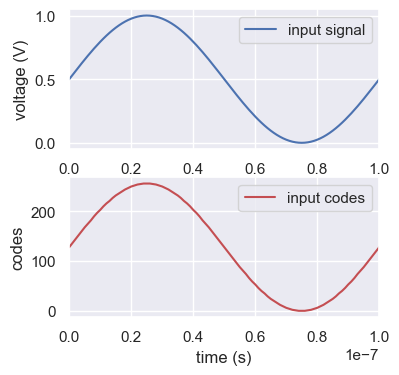

In [4]:
# represent the input signal and codes
fig, ax = plt.subplots(2,1, figsize=(4,4))
ax[0].plot(tD, si, 'b', label='input signal')
ax[0].set_xlabel('time (s)')
ax[0].set_ylabel('voltage (V)')
ax[0].legend()
ax[1].plot(tD, incodes, 'r', label='input codes')
ax[1].set_xlabel('time (s)')
ax[1].set_ylabel('codes')
ax[1].legend()
ax[0].set_xlim([0, 1/(f1)])
ax[1].set_xlim([0, 1/(f1)])
ax[1].grid(True); ax[0].grid(True)

In [5]:
fF = 1e-15 # femto Farad
pF = 1e-12 # pico Farad

# model the binary weighted capacitor array
cu = 2 * fF # unit capacitance
c_array = cu * 2**np.arange(nbits) # capacitance array
c_array = np.array([cu] + list(c_array)) # capacitance array
c_array

array([2.00e-15, 2.00e-15, 4.00e-15, 8.00e-15, 1.60e-14, 3.20e-14,
       6.40e-14, 1.28e-13, 2.56e-13])

In [6]:
# model capacitance mismatch
u_dev = 0
std_dev = 0.05 # 5%-15% capacitance mismatch
c_mismatch = normal(u_dev, std_dev, size=c_array.shape)
c_array = c_array + c_mismatch*c_array
c_array, c_array.shape

(array([2.21006800e-15, 2.13942186e-15, 4.05686445e-15, 8.57235741e-15,
        1.71047316e-14, 3.30101900e-14, 6.46003377e-14, 1.29554321e-13,
        2.67155214e-13]),
 (9,))

In [7]:
# model the total accumulated charge in phase 1 in function of the input code of the dac
def charge_ph1(incode, c_array, vref, ofst=0, cpb=0, cpvn=0, invert_code = True):
    """ Computes the total accumulated charge in phase 1
    It is considered that: 
        -the input code is M(N,1) from LSB to MSB
        -the capacitor array is M(N,1) from LSB Cap to MSB Cap
    Params:
        incode: input code
        c_array: capacitor array
        vref: reference voltage
        ofst: offset voltage of the amplifier
        cpb: parasitic capacitance at the bottom plates of the capacitors
        cpvn: parasitic capacitance at the virtual v- input node of the amplifier
        invert_code: flag to invert the input code
    Return:
        charge_ph1: total accumulated charge in phase 1
    """
    icode = incode[::-1 if invert_code else 1]
    return (ofst-vref) * (icode.reshape((1,-1)) @ c_array.reshape((-1,1))) + vref * cpb + ofst * cpvn

# model the total accumulated charge in phase 2
def charge_ph2(c_array, vout, ofst=0, cpb=0, cpvn=0):
    """Computes the total accumulated charge in phase 2
    """
    return (ofst-vout) * np.sum(c_array) + vout * cpb + ofst * cpvn

# model the output voltage in function of the input code, vref and the capacitance array
def vout_dac(incode, c_array=None, vref=1, ofst=0, cpb=0, cpvn=0, invert_code = True):
    """ Computes the output voltage of the DAC
    It is considered that: 
        -the input code is M(N,1) from LSB to MSB
        -the capacitor array is M(N+1,1) from LSB Cap to MSB Cap
    Params:
        incode: input code
        c_array: capacitor array
        vref: reference voltage
        ofst: offset voltage of the amplifier
        cpb: parasitic capacitance at the bottom plates of the capacitors
        cpvn: parasitic capacitance at the virtual v- input node of the amplifier
    """
    return vref * charge_ph1(incode, c_array[1:], vref, ofst, cpb, cpvn, invert_code) / charge_ph2(c_array, vref, ofst, cpb, cpvn)

In [8]:
# compute the output voltage in function of the input code
codes = np.arange(2**nbits)
incodes_bin = dec2bin(codes, nbits)

# in this case, the offset of the amplifier is null, as well as the parasitic capacitances
vof = partial(vout_dac, c_array=c_array, vref=vref, ofst=0, cpb=0, cpvn=0, invert_code = True)
vodac = np.vectorize(vof, signature='(k)->(m)')
vout = vodac(incodes_bin).flatten()
incodes_bin, vout.shape

(array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 1],
        [0, 0, 0, ..., 0, 1, 0],
        ...,
        [1, 1, 1, ..., 1, 0, 1],
        [1, 1, 1, ..., 1, 1, 0],
        [1, 1, 1, ..., 1, 1, 1]]),
 (256,))

Text(0.5, 1.0, 'DAC Transfer Function')

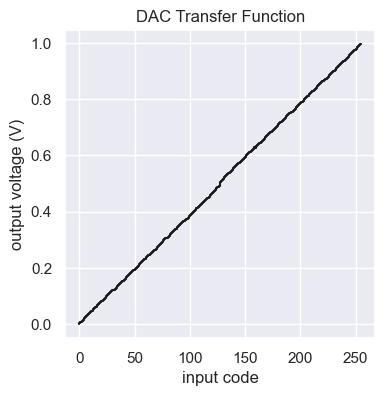

In [9]:
# plot the output voltage in function of the input code
fig, ax = plt.subplots(1,1, figsize=(4,4))
ax.step(codes, vout, 'k', label='output voltage')
ax.set_xlabel('input code')
ax.set_ylabel('output voltage (V)')
ax.grid(True)
ax.set_title('DAC Transfer Function')

In [10]:
# compute the inl and dnl
vlsb_measured = (vout[2**nbits - 1] - vout[0])/(2**nbits - 1)
dnl = np.diff(vout)/vlsb_measured - 1
inl = np.array([0] + np.cumsum(dnl).tolist())
assert len(dnl) == 2**nbits - 1, 'DNL length is not correct: {}'.format(len(dnl))
assert len(inl) == 2**nbits
# compute the effective number of bits of the DAC using the INL (once the lost bits can be compute by the 
# difference between the minimum and maximum value of the INL)
dac_linearity = nbits - np.log2(np.max(inl) - np.min(inl))
dac_linearity

6.038724004017272

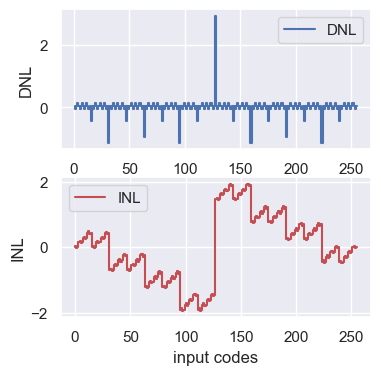

In [11]:
# plot the DNL and INL
fig, ax = plt.subplots(2,1, figsize=(4,4))
ax[0].step(codes[1:], dnl, 'b', label='DNL')
ax[0].set_xlabel('input codes')
ax[0].set_ylabel('DNL')
ax[0].legend()
ax[0].grid(True)
ax[1].step(codes, inl, 'r', label='INL')
ax[1].set_xlabel('input codes')
ax[1].set_ylabel('INL')
ax[1].legend()
ax[1].grid(True)

In [12]:
# consider now a 10 mV offset voltage of the amplifier and 
# a parasitic capacitance equal to 10% of the total capacitance of the DAC
cpvn = 0.1 * np.sum(c_array) # parasitic capacitance at the virtual v- input node of the amplifier
cpb = cpvn # parasitic capacitance at the bottom plates of the capacitors
voff = 10e-3
vof = partial(vout_dac, c_array=c_array, vref=vref, ofst=voff, cpb=cpb, cpvn=cpvn, invert_code = True)
vodac = np.vectorize(vof, signature='(k)->(m)')
vout = vodac(incodes_bin).flatten()
incodes_bin, vout.shape

(array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 1],
        [0, 0, 0, ..., 0, 1, 0],
        ...,
        [1, 1, 1, ..., 1, 0, 1],
        [1, 1, 1, ..., 1, 1, 0],
        [1, 1, 1, ..., 1, 1, 1]]),
 (256,))

Text(0.5, 1.0, 'DAC Transfer Function')

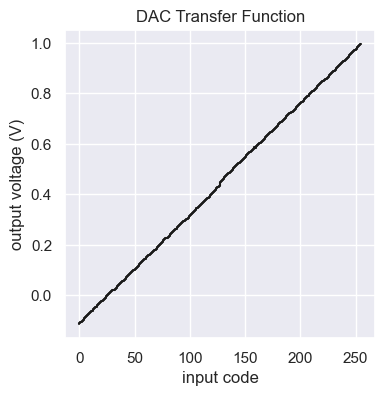

In [13]:
# plot the output voltage in function of the input code
fig, ax = plt.subplots(1,1, figsize=(4,4))
ax.step(codes, vout, 'k', label='output voltage')
ax.set_xlabel('input code')
ax.set_ylabel('output voltage (V)')
ax.grid(True)
ax.set_title('DAC Transfer Function')

In [14]:
# compute the inl and dnl
vlsb_measured = (vout[2**nbits - 1] - vout[0])/(2**nbits - 1)
dnl = np.diff(vout)/vlsb_measured - 1
inl = np.array([0] + np.cumsum(dnl).tolist())
assert len(dnl) == 2**nbits - 1, 'DNL length is not correct: {}'.format(len(dnl))
assert len(inl) == 2**nbits
# compute the effective number of bits of the DAC using the INL (once the lost bits can be compute by the 
# difference between the minimum and maximum value of the INL)
dac_linearity = nbits - np.log2(np.max(inl) - np.min(inl))
dac_linearity

6.038724004017263

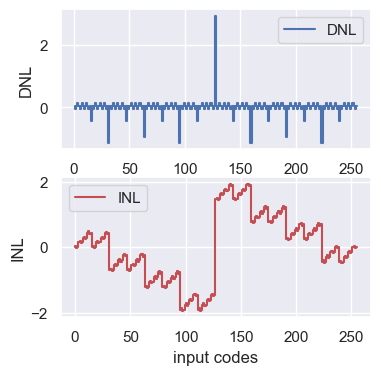

In [15]:
# plot the DNL and INL
fig, ax = plt.subplots(2,1, figsize=(4,4))
ax[0].step(codes[1:], dnl, 'b', label='DNL')
ax[0].set_xlabel('input codes')
ax[0].set_ylabel('DNL')
ax[0].legend()
ax[0].grid(True)
ax[1].step(codes, inl, 'r', label='INL')
ax[1].set_xlabel('input codes')
ax[1].set_ylabel('INL')
ax[1].legend()
ax[1].grid(True)

<p align="justify">
As it is possible to observe, the presence of an offset voltage and parasitics do not affect this DAC architecture, being primarily limitted by the capacitor mismatch each component is subjected to. This is due that the offset and the effect of the parasitic capacitances are present in both phases of the charge redistribution process, nulling out each other.
</p>